# Best regressor with PCA
En este notebook se tienen en cuenta los resultados de la busqueda del mejor algortimo de regresión obtenidos anteriomente, en esta ocasion se parte que _Random Forest_ fue el algoritmo que mejor capacidad de generalización mostro para cada uno de los conjuntos de datos. Por otra parte, se tomará esta vez para entrenar el algoritmo de _Random Forest_ solo que en esta ocasión se usará un conjunto de datos con una dimensionalidad menor. Para disminuir la dimensionalidad del conjunto de entrenamiento se usa análisis de componentes principlaes ( _PCA_).

## Importar librerias

In [1]:
import os
import cv2
import time
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score

## Cargar todos los data set en una lista. 

In [2]:
all_data = []
for data_frame in glob.glob("*.csv"):
    data = pd.read_csv(str(data_frame))
    all_data.append(data)

Se selecciona el conjunto de datos con el que se va a trabajar posibles opciones: $[0,1,2,3]$

In [3]:
# data_set_number = 0,1,2,3
data_set_number = 2
data_select = all_data[data_set_number]

In [4]:
data_select

,surface_tension,molecular_formula,density_liquid,enthalpy_fusion,enthalpy_vaporization,enthalpy_vaporization_boiling,thermal_expansion,C,Br,Cl,O,F,H,N,I,Si,S,Al,Ga,molecular_weight
0,2.06,CH3F,0.5283,1.426,15.686,17.670,0.008332,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,34.032966
1,3.01,C2H3F,0.6150,2.736,16.219,18.322,0.006303,2.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,46.043706
2,4.59,C2H3F3,1.0780,6.192,18.448,19.459,0.005488,2.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,84.040512
3,3.95,C2HF5,1.2166,2.250,18.372,19.147,0.005306,2.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,120.021437
4,6.08,C2HF3,1.2782,9.068,18.097,19.142,0.005126,2.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,82.024630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3372,11.46,C38H78,0.9101,85.444,72.163,71.757,0.000523,38.0,0.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,535.027518
3373,48.43,C2H6O2,1.1100,9.958,41.292,52.495,0.000455,2.0,0.0,0.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,62.067936
3374,53.72,C6H15Al,0.8350,10.600,44.632,60.677,0.000391,6.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,1.0,0.0,114.165093
3375,39.11,C7H9N,0.9810,13.400,40.107,43.871,0.000383,7.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,107.153352


## Normalización de los datos

Se tienen los datos en su estado natural y se normalizan con el StandarScaler de Scikitlearn, teniendo en cuenta que:

$z = \frac{X-\mu}{\sigma}$,

Donde $\mu$ y $\sigma$ son la media y la desviación estandar por columna.
Además, se divide el conjunto de datos en entrenamiento y prueba.

In [5]:
X = np.array(data_select.iloc[:,2:24])
scaler = StandardScaler()
scaler.fit(X)
X_norm = scaler.transform(X)
y = np.array(data_select['surface_tension'])
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.15, random_state=42)

## Correlación entre los datos

Se determina qué tan relacionado están los datos a partir del calculo de la matriz de correlación.

In [6]:
M_corr = np.corrcoef(X_norm, rowvar=False)

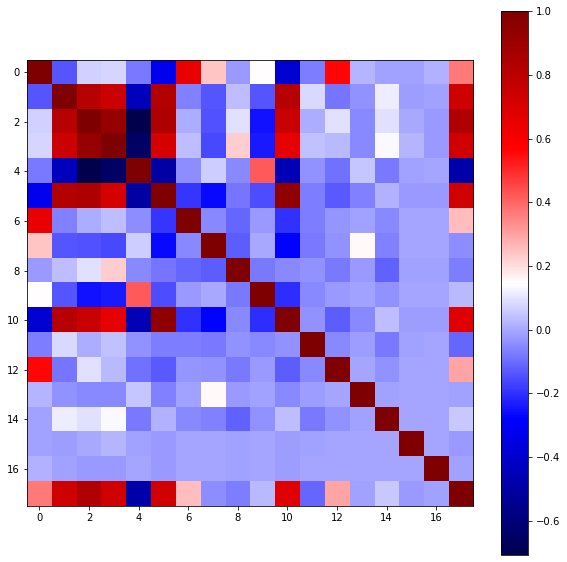

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(M_corr, cmap="seismic")
plt.colorbar()
plt.show()

## PCA para los datos de entrenamiento

A apartir de PCA, es posible hacer una redución en la dimensionalidad de los datos, como se puede ver en este momento el `X_norm.shape` = $\left(\text{n_datos}, 19\right)$, esto quiere decir que el conjunto de datos vive en un espacio que $\in \mathbb{R}^{19}$, la idea entonces es llegar aun dimensión menor a partir de esta tecnica que esta fundamentada teóricamente en la descomposición en valores singulares _(SVD)_.

In [8]:
pca = PCA(n_components=0.99, svd_solver="auto")
pca.fit(X_norm)
X_pca = pca.transform(X_norm)

In [9]:
M_corr_pca = np.corrcoef(X_pca, rowvar=False)

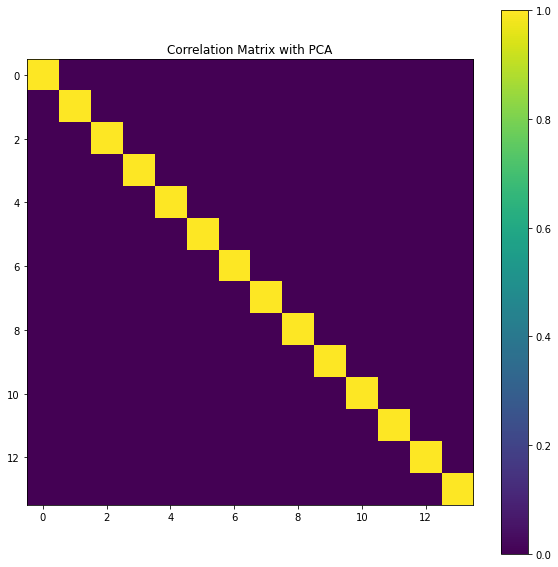

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(M_corr_pca)
plt.colorbar()
plt.title("Correlation Matrix with PCA")
plt.show()

Ahora, despues de tranformar sus datos en la nueva representación se obervan dos comportamientos. El primero, efectivamente se reduce la dimesionaldiad del conjunto de datos que dependiendo de este mismo cambia el numero de features que se reducen, por ejemplo para el caso que se presneta en este momento se pasa de $\mathbb{R}^{19} \longrightarrow \mathbb{R}^{15}$, lo que es una ventaja frente a timpos de computo. El segundo comportamiento es que se elimina la correlación que existe entre los datos ya que en este nuevo espacio de representación lo que se tiene son combinaciones lineales de las featrues originales.

In [11]:
y = np.array(data_select['surface_tension'])
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.15, random_state=42)

## Serach with new PCA data representation

In [12]:
hyperparameters = {'max_features': ["sqrt","log2"],
                  'n_estimators': [int(x) for x in np.linspace(start=1, stop=50, num=10)],
                  'max_depth': [int(x) for x in np.linspace(1, 110, num=10)],
                  'min_samples_split': [2, 4, 5, 6],
                  'min_samples_leaf': [1, 2, 4, 8],
                  "bootstrap": [True]}
RF_regression = RandomForestRegressor()
search = GridSearchCV(RF_regression, hyperparameters, cv = 3, verbose=3)
start_time = time.time()
parameters = search.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print("Elapsed time:", elapsed_time)

Fitting 3 folds for each of 3200 candidates, totalling 9600 fits
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.100 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=-1.336 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.045 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=6;, score=0.104 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=6;, score=0.159 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=6;, score=0.002 total time=   0.0s
[CV 1/3] END bootstrap=True, max_d

[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.110 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.083 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.105 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.118 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.078 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.122 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_s

[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.110 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.094 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.090 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.109 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.108 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.154 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_s

[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.167 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.040 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=33;, score=0.103 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=33;, score=0.104 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=33;, score=0.091 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=39;, score=0.104 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_s

[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.089 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.055 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=28;, score=0.121 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=28;, score=0.078 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=28;, score=0.115 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=33;, score=0.105 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_s

[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.142 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.125 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.213 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.067 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.125 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.241 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_s

[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.052 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.119 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.169 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.153 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.133 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.183 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_s

[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.164 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.127 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.268 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.198 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.131 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.212 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_s

[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.203 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.109 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.193 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.239 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.112 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.193 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_s

[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.098 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=-0.012 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.127 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.153 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.048 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.126 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_

[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.022 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.123 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.138 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.096 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=28;, score=0.123 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=28;, score=0.150 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_s

[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.129 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.074 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.147 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.025 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.098 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.132 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_s

[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.148 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.099 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.108 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.085 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.081 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=28;, score=0.122 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_s

[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.114 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.182 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.036 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.121 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.178 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.177 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_s

[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.081 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.170 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.100 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.101 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.169 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.052 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_s

[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.191 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.190 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.102 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.211 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.151 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.113 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_s

[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.267 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.234 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.062 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.251 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.211 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.128 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_s

[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.384 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.736 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.775 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.363 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.740 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.806 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=6;, score=0.743 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.381 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.735 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.815 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.380 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.762 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_sam

[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.821 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.279 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.599 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.661 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=6;, score=0.413 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=6;, score=0.634 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples

[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=39;, score=0.808 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=44;, score=0.355 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=44;, score=0.733 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=44;, score=0.821 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.353 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.717 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.823 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=33;, score=0.370 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=33;, score=0.745 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=33;, score=0.801 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.373 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.742 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.809 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.382 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.737 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.805 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.349 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.754 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.332 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.719 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.775 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.348 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.717 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.764 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.314 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.692 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.774 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.358 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.750 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.794 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.413 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.755 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.794 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.371 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.763 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.802 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_sa

[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.311 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.733 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.720 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.377 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.765 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.828 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_sa

[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.380 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.714 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.803 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.367 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.739 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.766 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_sa

[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.354 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.720 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.761 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.344 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.714 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.790 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_sa

[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.363 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.694 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.767 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.383 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.754 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.823 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_sa

[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=11;, score=0.329 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=11;, score=0.717 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=11;, score=0.670 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.369 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.743 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.783 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_sa

[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.732 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.788 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.356 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.735 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.787 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.332 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.354 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.695 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.818 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.370 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.687 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.808 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.342 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.710 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.828 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.374 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.732 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.865 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.322 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.762 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.785 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.394 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.748 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.784 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.380 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.756 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.828 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.375 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.757 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.819 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.350 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.762 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.793 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.382 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.726 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.799 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=6;, score=0.715 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=6;, score=0.662 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.385 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.718 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.790 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.369 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samp

[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.758 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.814 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1;, score=0.316 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1;, score=0.606 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1;, score=0.260 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=6;, score=0.324 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_sample

[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.758 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.820 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.365 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.714 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.804 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.359 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.823 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=33;, score=0.344 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=33;, score=0.707 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=33;, score=0.795 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=39;, score=0.329 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=39;, score=0.736 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.797 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.358 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.731 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.807 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.342 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.741 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.384 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.719 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.739 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.408 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.694 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.833 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_sa

[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=6;, score=0.775 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.341 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.739 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.846 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.381 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.763 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_sam

[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.824 total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.286 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.289 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=-0.316 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=6;, score=0.343 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=6;, score=0.696 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_sample

[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=39;, score=0.818 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=44;, score=0.368 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=44;, score=0.711 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=44;, score=0.801 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.382 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.745 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.796 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=33;, score=0.396 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=33;, score=0.755 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=33;, score=0.799 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.357 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.759 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.831 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.364 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.738 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.807 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.375 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.757 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_sa

[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.349 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.718 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.801 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.357 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.732 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.772 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_sa

[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6;, score=0.810 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.345 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.708 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.776 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.331 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.712 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_sam

[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.792 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.292 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.619 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.545 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=6;, score=0.366 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=6;, score=0.765 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples

[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=39;, score=0.839 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.370 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.729 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.864 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.381 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.731 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=28;, score=0.832 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.377 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.740 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.849 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.384 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.756 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.830 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.402 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.736 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.824 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.380 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.754 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.429 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.691 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.812 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.359 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.709 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.818 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=11;, score=0.366 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=11;, score=0.727 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=11;, score=0.804 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.357 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.710 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.765 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.341 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.745 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.803 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.384 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.763 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.766 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=11;, score=0.331 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=11;, score=0.707 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=11;, score=0.769 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.338 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.721 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.788 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.339 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.716 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.764 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.346 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.714 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.787 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.395 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.559 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.817 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.456 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.743 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.836 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_sa

[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.345 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.748 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.766 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.384 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.725 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.852 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_sa

[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.763 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.412 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.773 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.830 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.398 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.746 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.836 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.380 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.696 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.840 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.352 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.741 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=11;, score=0.745 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.388 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.741 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.765 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.355 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.723 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.806 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.344 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.767 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.822 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.355 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.745 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_sa

[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=6;, score=0.348 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=6;, score=0.686 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=6;, score=0.747 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=11;, score=0.336 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=11;, score=0.739 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=11;, score=0.780 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_sampl

[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.362 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.725 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.822 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1;, score=0.396 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1;, score=0.011 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1;, score=0.641 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_sampl

[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=39;, score=0.740 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=39;, score=0.856 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.369 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.749 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.857 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.387 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.837 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.384 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.750 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.855 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.382 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.764 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.742 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.816 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.366 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.721 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.830 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=33;, score=0.359 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.705 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.726 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.356 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.720 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.748 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.349 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.756 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.367 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.727 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.808 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.373 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.755 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=11;, score=0.799 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.333 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.755 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.840 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.339 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.758 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.795 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.333 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.722 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.812 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.328 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.722 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.364 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.705 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.778 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.358 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.727 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.795 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.750 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.816 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.393 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.726 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.814 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.403 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_sa

[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.753 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.678 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.348 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.737 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.851 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.388 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_sa

[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.746 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.825 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.343 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.740 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.763 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.384 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.779 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.391 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.729 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.800 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.393 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.699 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.817 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.338 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.766 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.792 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.375 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.754 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_sa

[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=11;, score=0.728 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=11;, score=0.754 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.372 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.697 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.830 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.340 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.759 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.337 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.699 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.807 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.333 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.731 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_sa

[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.110 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6;, score=0.288 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6;, score=0.704 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6;, score=0.806 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.340 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.692 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_sample

[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=44;, score=0.818 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.334 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.741 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.800 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.367 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.519 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samp

[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=39;, score=0.384 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=39;, score=0.747 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=39;, score=0.856 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.385 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.733 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.849 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=28;, score=0.403 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=28;, score=0.689 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=28;, score=0.827 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.401 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.738 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.845 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.770 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.413 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.725 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.823 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.375 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.744 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.715 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.740 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.385 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.736 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.785 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.389 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=11;, score=0.753 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.369 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.766 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.815 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.361 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.720 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.790 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.356 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.735 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.807 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.336 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.746 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1;, score=-0.249 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=6;, score=0.353 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=6;, score=0.705 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=6;, score=0.770 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=11;, score=0.336 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=11;, score=0.696 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_sampl

[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.345 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.727 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.810 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1;, score=0.247 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1;, score=0.525 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1;, score=0.598 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_sampl

[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=39;, score=0.370 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=39;, score=0.767 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=39;, score=0.863 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.397 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.749 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.839 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_sa

[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.372 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.725 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.851 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.384 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.718 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.830 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_sa

[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.843 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.367 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.755 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.846 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.385 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.748 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.836 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.353 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.648 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.811 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.346 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.769 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.774 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.350 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.720 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.834 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.363 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.758 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=11;, score=0.818 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.351 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.770 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.829 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.358 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.750 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.814 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.328 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.730 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.806 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.343 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.743 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6;, score=0.385 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6;, score=0.709 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6;, score=0.773 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.363 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.698 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.804 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_sampl

[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.730 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.811 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.132 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.563 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.685 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=6;, score=0.352 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_sample

[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=39;, score=0.844 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.408 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.767 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.830 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.399 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.748 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=28;, score=0.837 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.378 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.748 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.848 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.373 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.723 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.813 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.387 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.728 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.828 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.376 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.703 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.695 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.846 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.362 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.750 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.810 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.354 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=11;, score=0.763 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.364 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.756 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.801 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.348 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.748 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.784 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.425 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.736 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.812 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.370 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.766 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=11;, score=0.807 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.336 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.727 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.765 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.357 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.741 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.804 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.362 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.719 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.808 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.308 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.719 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.748 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.836 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.376 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.755 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.823 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.339 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_sa

[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.752 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.811 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.336 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.762 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.831 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.363 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_sa

[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.328 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.753 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.778 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.375 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.732 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.780 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.691 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.381 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.705 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.843 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.374 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.721 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_sa

[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=11;, score=0.757 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=11;, score=0.807 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.341 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.671 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.818 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.386 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_sa

[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.755 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.662 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.356 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.725 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.811 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.377 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=11;, score=0.775 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.347 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.724 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.768 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.338 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.731 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_sa

[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.718 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.813 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.349 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.717 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.815 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.344 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_sa

[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.756 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.856 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.400 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.751 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.822 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.379 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.393 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.611 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.834 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.366 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.729 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.830 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.749 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.796 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.400 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.725 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.762 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.396 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.738 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.812 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.392 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.718 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.816 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.364 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=11;, score=0.368 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=11;, score=0.722 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=11;, score=0.784 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.353 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.742 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.793 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.694 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.807 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.397 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.730 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.819 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.396 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=11;, score=0.778 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.337 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.751 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.810 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.335 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.716 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=6;, score=0.693 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=6;, score=0.794 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.353 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.704 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.799 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.363 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samp

[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.764 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.856 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1;, score=0.219 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1;, score=0.426 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1;, score=0.649 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=6;, score=0.354 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_sample

[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.762 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.810 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=44;, score=0.371 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=44;, score=0.764 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=44;, score=0.837 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.381 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_sa

[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.749 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.858 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=33;, score=0.344 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=33;, score=0.728 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=33;, score=0.839 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.350 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.805 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.380 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.716 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.808 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=28;, score=0.382 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=28;, score=0.747 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.783 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.382 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.752 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.819 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.367 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.750 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=11;, score=0.801 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.374 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.722 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.820 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.335 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.722 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.780 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.345 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.728 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.800 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.344 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.729 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.363 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.730 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.782 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.363 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.722 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.797 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_sa

[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.762 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.810 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.365 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.739 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.822 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.393 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.720 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.836 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.433 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.734 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.825 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.412 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.719 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.805 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.370 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.748 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.809 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.404 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.795 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.390 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.733 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.752 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.365 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.738 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.770 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.374 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.733 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.820 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.391 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.747 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=11;, score=0.782 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.346 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.754 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.807 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.364 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.728 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.322 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.737 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.781 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.361 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.715 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.807 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6;, score=0.304 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6;, score=0.702 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=6;, score=0.725 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.358 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.724 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.752 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_sampl

[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.738 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.811 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.274 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.655 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.695 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=6;, score=0.323 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_sample

[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=39;, score=0.838 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.377 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.747 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.854 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.376 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.752 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_sa

[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.388 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.749 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.814 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.364 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.760 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.841 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_sa

[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.828 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.375 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.752 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.833 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=33;, score=0.369 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=33;, score=0.746 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.780 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.340 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.751 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.824 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.392 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.714 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=11;, score=0.772 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.354 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.726 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.802 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.356 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.730 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.810 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.362 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.751 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.818 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.373 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.725 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_sa

[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.366 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.700 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.813 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.363 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.707 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.803 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.348 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.730 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.813 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.376 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.711 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.801 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_sa

[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.792 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.385 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.691 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.858 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.416 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.750 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1,

[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.814 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.383 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.760 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.806 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.358 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.728 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1,

[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.708 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.802 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.358 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.731 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.790 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.368 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2,

[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.735 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.350 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.740 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.829 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.378 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.705 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2,

[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=11;, score=0.749 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.371 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.716 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.821 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.344 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.725 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4,

[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.822 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.371 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.732 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.816 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.364 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.724 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4,

[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.348 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.710 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.799 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.313 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.723 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.802 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8,

[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.333 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.703 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.791 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.351 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.718 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.826 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8,

[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.833 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.362 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.740 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.851 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.406 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.749 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1,

[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.860 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.423 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.634 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.772 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.372 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.732 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1,

[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.811 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.398 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.718 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.784 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.363 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.731 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2,

[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.796 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.399 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.733 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.823 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.379 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.732 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2,

[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=11;, score=0.830 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.398 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.742 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.797 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.359 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.723 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4,

[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1;, score=0.713 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=6;, score=0.345 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=6;, score=0.668 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=6;, score=0.790 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.372 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.755 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min

[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.805 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.365 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.748 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.793 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1;, score=0.214 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1;, score=0.624 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, m

[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=39;, score=0.358 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=39;, score=0.726 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=39;, score=0.810 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.359 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.741 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.799 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8,

## Entrenamiento con los resultados de la busqueda. 

In [13]:
RF_regression = RandomForestRegressor(**parameters.best_params_)
model = RF_regression.fit(X_train,y_train)

## Predicción a partir del modelo 

In [14]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(len(y_pred), 1)

In [15]:
last_regression = LinearRegression()
last_model = last_regression.fit(y_test.reshape(len(y_test), 1), y_pred)
last_model.coef_

array([[0.85508175]])

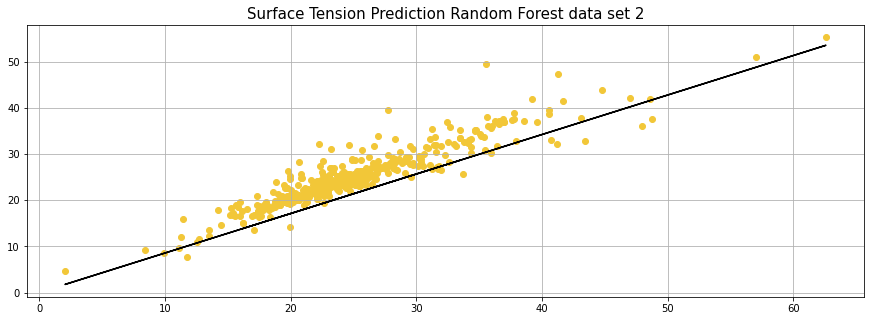

In [16]:
plt.figure(figsize=(15, 5))
plt.scatter(y_test.reshape(len(y_test), 1), y_pred, color='#f2c738') 
line = last_model.coef_*y_test
plt.plot(y_test.reshape(len(y_test), 1), line.reshape(len(y_test), 1), color='k') 
plt.title(f'Surface Tension Prediction Random Forest data set {data_set_number}', fontsize=15)
plt.savefig(f"PCA_surface_tension_prediction_type_random_forest_data_set_number_{data_set_number}")
plt.grid()
plt.show()

## Métricas

In [17]:
score = r2_score(y_test, y_pred)
print("Mean squared error:", mean_squared_error(y_test, y_pred))
print("Coefficient of determination:", score)

Mean squared error: 5.78016907772863
Coefficient of determination: 0.8603044839470935


In [18]:
def feature_importance(model):
    result = permutation_importance(model, X_train, y_train, n_repeats=10,
                                random_state=0)
    return result

In [19]:
importance = feature_importance(model)
mean = importance.importances_mean
tot = sum(mean)
hist=[]
for i in range(len(mean)):
    clc = (mean[i]*100)/tot
    hist.append(clc)
print(hist)

[11.968801903743413, 32.260950929232514, 15.21694123721645, 3.6486382436494345, 5.080573468690559, 4.538924304496918, 2.6193094139231454, 3.4797345117652965, 2.103014757899554, 5.031864735001602, 0.9555020080813073, 1.4841343237227898, 7.698378551362043, 1.2343769682253247, 2.6788546429896516]


In [20]:
labels = []
for i in range(len(hist)):
    ind = str(i) 
    labels.append('Feature '+ind)
print(labels)

['Feature 0', 'Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5', 'Feature 6', 'Feature 7', 'Feature 8', 'Feature 9', 'Feature 10', 'Feature 11', 'Feature 12', 'Feature 13', 'Feature 14']


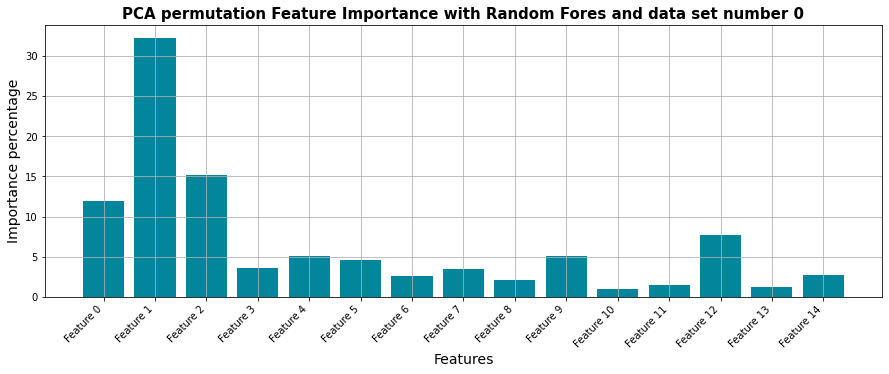

In [21]:
plt.figure(figsize=(15, 5))
plt.bar(labels, hist, color='#03859c')
plt.title(f'PCA permutation Feature Importance with Random Fores and data set number {data_set_number}', 
          fontsize=15, fontweight="bold")
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance percentage', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.savefig(f"PCA feature_importance_with_random_forest_data_set_number_{data_set_number}")